# IBM Article Recommendations

<hr>

## Table of Contents

I. Exploratory Data Analysis<br>
II. Rank Based Recommendations<br>
III. User-User Based Collaborative Filtering<br>
IV. Matrix Factorization<br>
V. Extras & Conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import accuracy_score, f1_score, recall_score

df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')

In [2]:
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
display(df.head())

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
display(df_content.head())

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### Part 1 : Exploratory Data Analysis


1. What is the distribution of how many articles a user interacts with in the dataset?   

In [5]:
print("statistics of user interaction with the articles: ")
print(df.groupby(['email']).count().describe()['article_id'])

statistics of user interaction with the articles: 
count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


In [6]:
print("count of articles opened by each user: ")
print(df.groupby('email').count().sort_values(by='title', ascending=False)['title'])

count of articles opened by each user: 
email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
9655144418d25a0e074616840447e6e5dbef0069      1
9656a8f1059d7af6be6ddaec889c66bc9d402b77      1
96654c6e066d002e5b44f6e9e38217c10c81f698      1
966ca71b9b2ea0dc5c0cb0cd9f523cdc7ad2f0cc      1
9678e0a3f95203d23df78f8d733d22eae4a07b0c      1
Name: title, Length: 5148, dtype: int64


bar chart of articles opened by top 40 active users: 


<Axes: xlabel='email'>

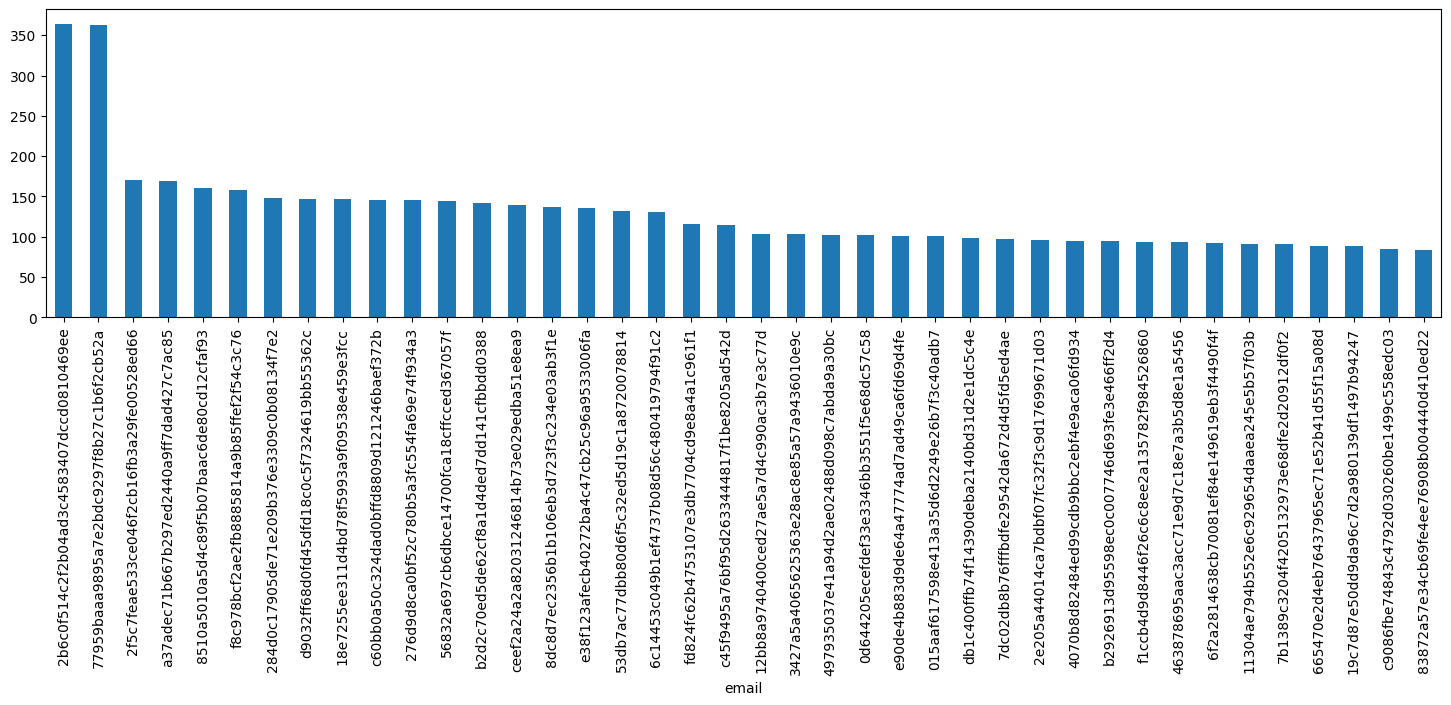

In [7]:
print('bar chart of articles opened by top 40 active users: ')
df.groupby('email').count().sort_values(by='title', ascending=False)['title'][:40].plot.bar(figsize=(18,4))

In [8]:
print("statistics of article viewership: ")
print(df.groupby(['article_id']).count().describe()['title'])

statistics of article viewership: 
count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: title, dtype: float64


In [9]:
print("list of article views from largest to lowest: ")
print(df.groupby('article_id').count().sort_values(by="title", ascending=False)["title"])

list of article views from largest to lowest: 
article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
984.0       1
1344.0      1
675.0       1
662.0       1
653.0       1
Name: title, Length: 714, dtype: int64


bar chart of 20 most frequently viewed articles: 
Axes(0.125,0.11;0.775x0.77)


/tmp/ipython-input-10-1003735077.py:2: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  print(df.groupby('article_id').count().sort_values(by='title', ascending= False)['title'][:20].plot.bar(figsize=(18,4)))


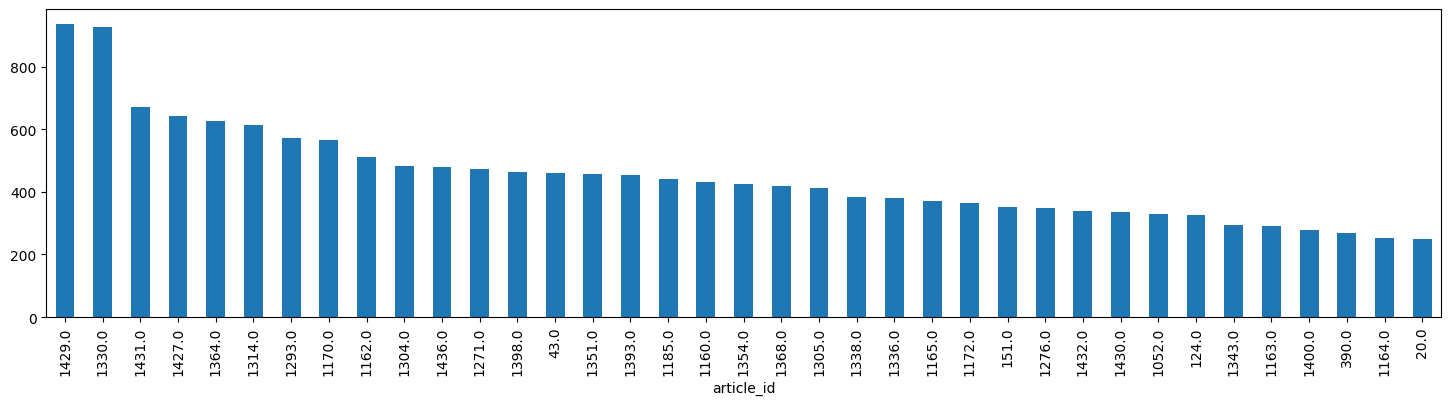

In [10]:
print("bar chart of 20 most frequently viewed articles: ")
print(df.groupby('article_id').count().sort_values(by='title', ascending= False)['title'][:20].plot.bar(figsize=(18,4)))

In [11]:
#filling in the median and maximum no. of user_article interations

median_val = df.groupby('email').count().median().iloc[0]  # 50% of users interact with [median_val] articles or fewer.
max_views_by_user = df.groupby('email').count().sort_values(by='title', ascending=False)['title'].iloc[0]  # The max interactions by any user is [max_views_by_user].

2. Exploring and removing duplicate articles from the **df_content** dataframe.  

In [12]:
print('total no. of articles: ', df_content.shape[0])
print('total no. of unique articles: ', df_content.article_id.nunique())
print('total no. of duplicate articles: ', df_content.shape[0] - df_content.article_id.nunique())

total no. of articles:  1056
total no. of unique articles:  1051
total no. of duplicate articles:  5


In [13]:
# duplicated articles

df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [14]:
#removing redundant rows w the same article id as the first one found keeping only the first one

df_content = df_content.drop_duplicates(subset='article_id', keep='first')
print('rows remaining after dropping duplicates: ', df_content.shape[0])

rows remaining after dropping duplicates:  1051


3. Now finding:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
unique_articles = df.article_id.unique().shape[0] # no. of unique articles hving atleast one interaction
total_articles = df_content.article_id.shape[0] # no. of unique articles on the IBM platform
unique_users = df.email.nunique() # no. of unique users
user_article_interactions = df.shape[0] # no. of user-article interactions

4. Finding the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
most_viewed_article = df.groupby('article_id', as_index=False).count().sort_values(by='title', ascending=False).iloc[0]
print(most_viewed_article)

article_id    1429.0
title          937.0
email          937.0
Name: 699, dtype: float64


In [17]:
most_viewed_article_id = str(list(most_viewed_article)[0]) # the most viewed article in the dataset as a string with one value following the decimal
max_views = list(most_viewed_article)[1] #no. of times the mist viewed article in dataset was viewed

In [18]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
           coded_dict[val] = cter
           cter +=1

        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

#testing dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### Part 2: Rank-Based Recommendations

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

1. The function below returns the **n** top articles ordered with most interactions as the top.

In [20]:
def get_top_articles(n, df=df):
  '''
  Input:
  n - (int) the no. of articles to return
  df - (pandas datafram) df as defined at the top of the notebook

  Output:
  top_articles - (list) a list of the top 'n' titles
  '''
  top_articles = list(df.groupby(['article_id', 'title'], as_index=False).count().sort_values(ascending=False, by='user_id').title[:n])
  return top_articles #returning top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
  '''
  Input:
  n - (int) the no. of articles to return
  df - (pandas datafram) df as defined at the top of the notebook

  Output:
  top_articles - (list) a list of the top 'n' ids
  '''

  top_articles = list(df.groupby(['article_id', 'title'], as_index=False).count().sort_values(ascending=False, by= 'user_id').article_id[:n])
  top_articles = list(map(str, top_articles))

  return top_articles #returning the top article ids

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [22]:
# testing fuction by returning the top 5, 10 and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# testing each of three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### Part 3: User-User Based Collaborative Filtering


1. The function below reformats the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** appears in each **row** once.


* Each **article** shows up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.

The tests make sure the basic structure of the matrix matches what is expected by the solution.

In [23]:
df.head(2)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2


In [24]:
def create_user_item_matrix(df):
  '''
  Input: df - pandas dataframe with article_id, title, user_id columns

  Output: user_item - user item matrix

  Description: Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with
    an article and a 0 otherwise
  '''

  user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
  user_item.fillna(0, inplace=True)

  for cols in user_item.columns.values:
      user_item[cols] = user_item[cols].apply(lambda x: x if x == 0 else 1)
  return user_item # returning user_item matrix

user_item = create_user_item_matrix(df)


In [25]:
# display(user_item.head())

In [26]:
# Testing my functions:

assert user_item.shape[0] == 5149, "Oops! the no. of users in the user-article matrix do not look right."
assert user_item.shape[1] == 714, "Oops! the no. of articles in the user-article matrix do not look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  the no. of articles seen by user 1 do not look right."

print("You hv passed our tests! Please proceed!")

You hv passed our tests! Please proceed!


2. The function below takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result doesn't contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

The tests below check the function we have created

In [27]:
def find_similar_users(user_id, user_item=user_item):

    '''
    Input:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    Output:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    '''
    # getting current user vector
    current_user_vec = user_item[user_item.index == user_id]

    #computing similarity of each user to the provided user
    similarity = current_user_vec.dot(user_item.T)

    #sorting by similarity
    similarity = similarity.iloc[0].sort_values(ascending= False)
    # print(similarity)

    #creating lists of just ids
    most_similar_users = list(similarity.keys())

    #removing the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users # returning the list of most similar users (order: most to least similar)

In [28]:
# Spot checking my function
print("the 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("the 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("the 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

the 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
the 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
the 3 most similar users to user 46 are: [4201, 3782, 23]


3. Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles that are to be recommended.  The functions below return the articles we would recommend to each user.

In [29]:
def get_article_names(article_ids, df=df):
    '''
    Input:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    Output:
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column)
    '''

    article_ids = list(map(float, article_ids))
    article_names = list(set(df.loc[df['article_id'].isin(article_ids)]['title'].values))
    return article_names # returning article names associated with list of article ids



def get_user_articles(user_id, user_item=user_item):
    '''
     Input:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    Output:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the doc_full_name column in df_content)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_colm = user_item.T[user_id]
    article_colm = article_colm[article_colm == 1]
    article_ids = list(article_colm.keys())
    article_names = get_article_names(article_ids)
    article_ids = list(map(str, article_ids))

    return article_ids, article_names # returning ids and names



def user_user_recs(user_id, m=10):
    '''
    Input:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    Output:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who have the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily
    '''

    similar_users = find_similar_users(user_id)

    #articles already seen by user
    article_ids_seen, article_names_seen = get_user_articles(user_id)

    recs = list()
    for user in similar_users:
        article_ids, article_names = get_user_articles(user)
        final_article_id = np.setdiff1d(article_ids, article_ids_seen, assume_unique = True)
        # print("final_article_id", final_article_id)
        # print("ty", type(final_article_id))

        recs.extend(final_article_id)
        recs = list(recs)
        if(len(recs) > m-1):
            break

    return recs[:m] #return your recommendations for this user id

In [30]:
user_user_recs(1, 10)

[np.str_('2.0'),
 np.str_('12.0'),
 np.str_('14.0'),
 np.str_('16.0'),
 np.str_('26.0'),
 np.str_('28.0'),
 np.str_('29.0'),
 np.str_('33.0'),
 np.str_('50.0'),
 np.str_('74.0')]

In [31]:
get_article_names(user_user_recs(1, 10)) # returning 10 recommendations for user 1

['using machine learning to predict parking difficulty',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'higher-order logistic regression for large datasets',
 'this week in data science (april 18, 2017)',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks']

In [32]:
# testing my funcs

assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("You hv again passed all of our tests!  Nice job!")

You hv again passed all of our tests!  Nice job!


4. Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we'll choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we'll choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [33]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    Input:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise


    Output:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where
                    highest of each is higher in the dataframe

    '''
    # getting current user vector
    current_user_vec = user_item[user_item.index == user_id]

    #computing similarity of each user to the provided user
    similarity = current_user_vec.dot(user_item.T)

    #compute the no. of user interactions of each article
    article_user_intr = df.groupby(["user_id"], as_index=False).count()

    #sorting by similarity
    similarity = similarity.iloc[0].sort_values(ascending= False)

    #converting into a datafram and renaming column
    vals_counts = pd.DataFrame(similarity).reset_index()
    vals_counts.rename(columns={user_id: 'similarity'}, inplace=True)

    # merging article_user_intr and val_counts dataframes and renaming cols
    df_merge = pd.merge(article_user_intr, vals_counts, on='user_id')
    df_merge.rename(columns={"article_id": "num_interactions","user_id": "neighbor_id" }, inplace=True)

    #sorting dataframe and removing own users id
    neighbors_df = df_merge.sort_values(by=['similarity', 'num_interactions'], ascending=False)[['neighbor_id', 'similarity', 'num_interactions']][1:]

    # increasing index to match the neighbour_id value
    neighbors_df.index += 1

    return neighbors_df # returning the dataframe specified in the doc_string


In [34]:
get_top_sorted_users(3).head()

,neighbor_id,similarity,num_interactions
3353,3353,40,80
23,23,23,364
3782,3782,23,363
98,98,17,170
3764,3764,17,169


In [35]:
def user_user_recs_part2(user_id, m=10):

    '''
    Input:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    Output:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    # get the list of the top rated articles
    top_articles = get_top_article_ids(unique_articles)
    top_articles = list(map(float, top_articles))
    similar_users = get_top_sorted_users(user_id)


    # articles already seen by user.
    article_ids_seen, article_names_seen = get_user_articles(user_id)

    recs = list()
    # print('similar_users', similar_users)
    for user in similar_users.neighbor_id:
        # print('su', user)
        article_ids, article_names = get_user_articles(user)

        final_artical_id = np.setdiff1d(article_ids, article_ids_seen, assume_unique=True)
        final_artical_id = np.intersect1d(top_articles, final_artical_id)

        recs.extend(final_artical_id)
        recs = list(recs)
        if(len(recs) > m-1):
            break

    rec_names = get_article_names(recs[:m])
    return recs[:m], rec_names

In [36]:
# quick spot check for func testing

rec_ids, rec_names = user_user_recs_part2(20, 10)
print ("the top 10 recommendations for user 20 are the following article ids:")
print (rec_ids)
print()
print ("the top 10 recommendations for user 20 are the following article names:")
print (rec_names)

the top 10 recommendations for user 20 are the following article ids:
[np.str_('1024.0'), np.str_('1085.0'), np.str_('109.0'), np.str_('1150.0'), np.str_('1151.0'), np.str_('1152.0'), np.str_('1153.0'), np.str_('1154.0'), np.str_('1157.0'), np.str_('1160.0')]

the top 10 recommendations for user 20 are the following article names:
['tensorflow quick tips', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: chicago listings', 'analyze accident reports on amazon emr spark', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: venice listings']


5. Use the functions from above to correctly fill in the solutions to the dictionary below.  Then test the dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [37]:
# tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] #find user most similar to user 1
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] #find the 10th most similar user to user 131

In [38]:
# dictionary test:

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


6. If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can we think of a better way we might make recommendations?  


The get_top_articles(10) could be used to make recommendations referring them to the most popular articles in general. Unfortunatly the current algorithms we have developed in the above notebook require some initial data to make recommendations. So a cold start problem such as this wont work. Content Based Recommendation Engines can be used to tackle this problem more effectively.

7. Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [39]:
new_user = "0.0"

# what would your recommendations be for this new user "0.0"? as a new user, they have no observed articles.
# provide a list of the top 10 article ids you would give to

new_user_recs = get_top_article_ids(10) # your recs

In [40]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### Part 5: Matrix Factorization

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

1.

In [41]:
user_item_matrix = pd.read_pickle("user_item_matrix.p")

In [42]:
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Using the cell to perform SVD, and explain why this is different than in the lesson.

In [43]:
# performing SVD on user-item matrix

u, s, vt = np.linalg.svd(user_item_matrix)


The matrix here represents a yes/no case where 1 means interaction 0 means no intereactions. It also consists of no missing (nan) values which would result in an error. Therefore, we do not need to user FunkSVD or induge in clearning/pre processing because we have no or nan values and a simpler case of 0-1 (Yes/No).

<hr>

3. Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, We can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Running the cell below gives an idea of how the accuracy improves as we increase the number of latent features.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, 'Accuracy vs No. Latent Features')

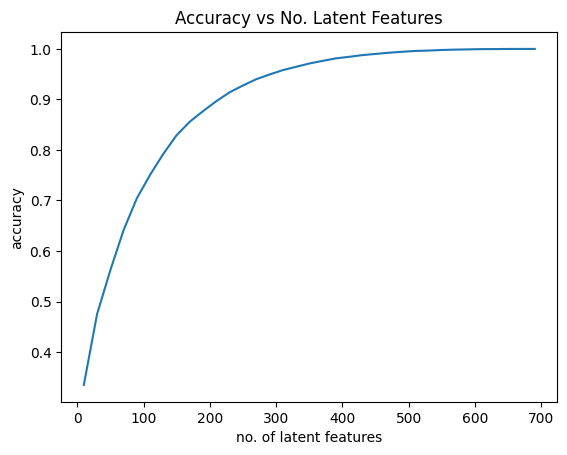

In [44]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructuring with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[: , :k], vt[:k, :]

    # taking dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    #computing error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keeping track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel("no. of latent features")
plt.ylabel("accuracy")
plt.title("Accuracy vs No. Latent Features")

4. From the above graph, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication that if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

We'll use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below:

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [45]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    Input:
    df_train - training dataframe
    df_test - test dataframe

    Output:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids

    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # taking only uniqui values to avoid duplicates
    test_idx = set(user_item_test.index.values)
    test_arts = set(user_item_test.columns.values)

    # making sure the test data does not hv training or duplicate values in them
    user_item_test = user_item_test.loc[list(test_idx.intersection(set(user_item_train.index))), list(test_arts.intersection(set(user_item_train.columns)))]

    # changing type from set to list
    test_idx = list(test_idx)
    test_arts = list(test_arts)

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [47]:
# no. of users we can predict for in the test set

user_item_test.shape[0]

20

In [48]:
# no. of users in the test set that we are not able to make predictions for because of the cold start problem

len(test_idx) - user_item_test.shape[0]

662

In [49]:
# no. of articles we can predict in the test set

user_item_test.shape[1]

574

In [50]:
# no. of articles in the test set that we are not able to make predictions for because of the cold start problem

len(test_arts) - user_item_test.shape[1]

0

In [51]:
# replacing following values in the dictionsary

a = 662
b = 574
c = 20
d = 0

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


5. Now using the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then finding the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Using the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [52]:
# fitting SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [53]:
u_test = u_train[user_item_train.index.isin(test_idx),:]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

In [54]:
u_test.shape

(20, 4487)

In [56]:
# checking how well I can use the training
# decomposition to predict on test data
num_latent_feats = np.arange(0, 700+10, 20)
accuracy_train = []
accuracy_test = []
f1score_train = []
f1score_test = []

for k in num_latent_feats:
    # restructuring w k latent features
    s_train_latent_f, u_train_latent_f, vt_train_latent_f = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_latent_f, vt_test_latent_f = u_test[:, :k], vt_test[:k, :]

    #taking dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_latent_f, s_train_latent_f), vt_train_latent_f))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_latent_f, s_train_latent_f), vt_test_latent_f))

    # finding accuracy
    acc_train = accuracy_score(np.array(user_item_train).flatten(), user_item_train_preds.flatten())
    acc_test = accuracy_score(np.array(user_item_test).flatten(), user_item_test_preds.flatten())

    # fi score
    f1_train = f1_score(np.array(user_item_train).flatten(), user_item_train_preds.flatten(), average='macro')
    f1_test = f1_score(np.array(user_item_test).flatten(), user_item_test_preds.flatten(), average='macro')

    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
    f1score_train.append(f1_train)
    f1score_test.append(f1_test)


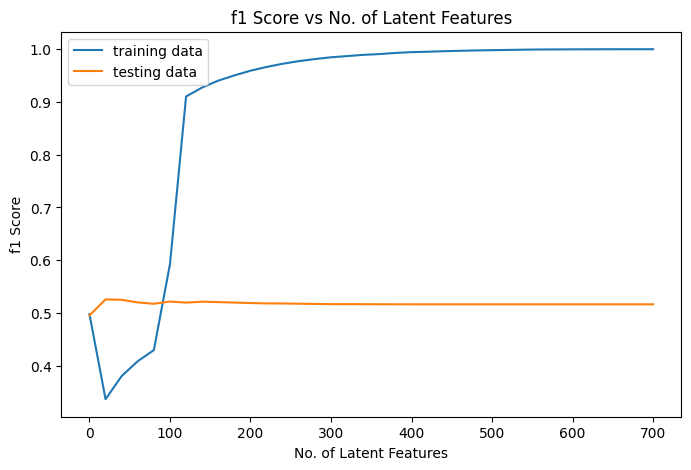

In [57]:
plt.rcParams["figure.figsize"] = (8, 5)

plt.plot(num_latent_feats, f1score_train, label="training data")
plt.plot(num_latent_feats, f1score_test, label='testing data')
plt.xlabel('No. of Latent Features')
plt.ylabel('f1 Score')
plt.title('f1 Score vs No. of Latent Features')
plt.legend()

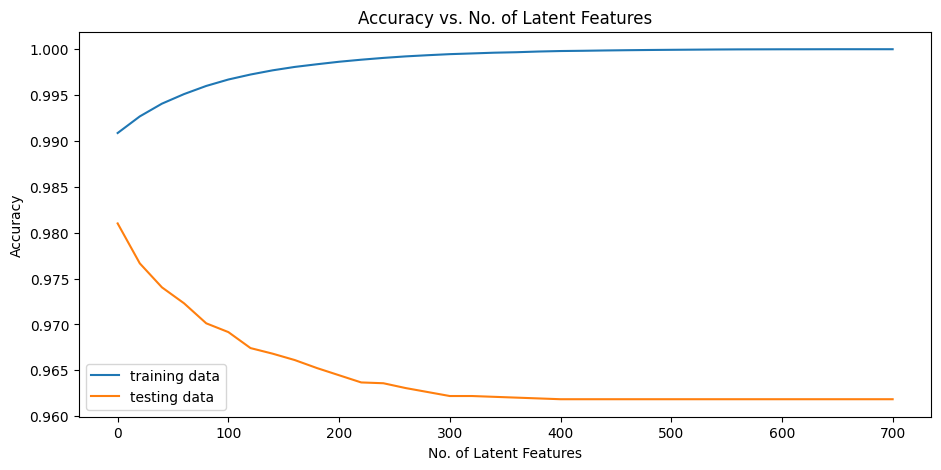

In [58]:
plt.rcParams["figure.figsize"] = (11, 5)

plt.plot(num_latent_feats, accuracy_train, label="training data")
plt.plot(num_latent_feats, accuracy_test, label='testing data')
plt.xlabel('No. of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of Latent Features')
plt.legend()

 6. Comment on the results found in the previous question. Given the circumstances of the results, discuss what we might do to determine if the recommendations we make with any of the above recommendation systems are an improvement to how users currently find articles?

The increase of accuracy in the training and the subsequent decrease of accuracy in test data reveals that the model is overfitting as the number of latent features increase. The reverse/inverse relationship between the two is quite perplexing and since there is no covergence betwene the two lines, it has hard to determine the exact number of latent features that would be the right fit. However the number of latent features need to be kept low as soon as possible to avoid as much overfitting as we can.

Only 20 users existed between the test and training set. This is too few to evaluate the performance. That coupled with the fact that the matrix is extremely sparce with a greater number of zeros has lead to a class imbalance problem.

Similarly the F1 score graphs shows that that at around 100 latent features, both the testing and training score coverged. While the training score increases, the testing score remains roughly constant at about 0.5 which is not a very positive result. The model does not perform well on test data.

Therefore we can conclude that the system does not generalize well on test data.

A/B Testing could be a viable option where users are divided between 2 groups, with the first a control and the other an experiment which uses the recommender system. That way we can have much better evaluation results on our recommender systems performace.

Other parameters that can be kept in mind is how much time the user spent on an article. If the time is < 2 sec it means that he didnt browse through it and its value or interaction should be low in comparision to another user who spent > 20 sec on the articles. These metrics would let us know whether the user accurately read the article or not. Other metrics such as rating an article may be a far better evaluation metric to determine performance.
